https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

https://towardsdatascience.com/computer-vision-feature-extraction-101-on-medical-images-part-3-difference-of-gaussian-and-b3cbe5c37415

In [45]:
# All the libraries used
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import time
import random
import math

from scipy.ndimage import imread # Need to use scipy 1.1.0 to run imread
import scipy.ndimage
from scipy.misc import imresize
import scipy 
import seaborn as sns

In [46]:
path = "resized_diabetic_2015/resized_train_cropped/resized_train_cropped"  

In [47]:
target = pd.read_csv("resized_diabetic_2015/trainLabels_cropped.csv")
target.sample(10)

,Unnamed: 0,Unnamed: 0.1,image,level
9281,9281,9288,11677_left,0
6542,6542,6546,8233_left,2
3661,3661,3665,4582_right,1
27535,27535,27551,34880_right,0
1304,1304,1306,1630_left,0
1006,1006,1007,1233_right,2
14101,14101,14110,17722_left,0
17089,17089,17100,21476_left,0
12340,12340,12349,15495_right,0
25883,25883,25898,32773_left,2


In [48]:
target['level'].value_counts()

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

In [49]:
level_0 = target["image"][target['level'] == 0].tolist()
level_1 = target["image"][target['level'] == 1].tolist()
level_2 = target["image"][target['level'] == 2].tolist()
level_3 = target["image"][target['level'] == 3].tolist()
level_4 = target["image"][target['level'] == 4].tolist()

K = 708
level_0 = random.choices(level_0,k=K)
level_1 = random.choices(level_1,k=K)
level_2 = random.choices(level_2,k=K)
level_3 = random.choices(level_3,k=K)
level_4 = random.choices(level_4,k=K)

In [50]:
# Creating X and Y 
X = np.concatenate((level_0,level_1,level_2,level_3,level_4))
Y = np.concatenate((np.zeros(K),np.ones(K),np.ones(K)*2,np.ones(K)*3,np.ones(K)*4))

In [51]:
# 0. Read the data into Numpy
n = len(X)
pixels = 224
one = np.zeros((n,pixels,pixels))

# 0.5 Transfer All of the Data into array
print('===== READING DATA ========')
for file_name in range(n):
    image_path = path+"/"+X[file_name]+".jpeg"
    one[file_name,:,:]   = imresize(imread(image_path,mode='F',flatten=True),(pixels,pixels))
print('===== Done READING DATA ========')

===== READING DATA ========


/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/haley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


===== Done READING DATA ========


## Histogram Equalization

In [115]:
n = len(X)
hist_data = np.zeros((n,224,224))
for i in range(n):
    image_path = path+"/"+X[i]+".jpeg"
    img = cv2.resize(cv2.imread(image_path,0),(224,224))
    equ = cv2.equalizeHist(img)
    hist_data[i,:,:] = equ

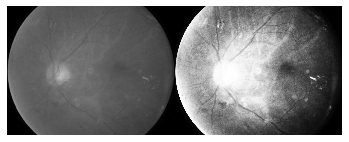

In [111]:
img1 = path+"/"+X[-1]+".jpeg"
img1 = cv2.imread(img1,0)
equ = cv2.equalizeHist(img1)
res = np.hstack((img1,equ)) #stacking images side-by-side
plt.axis('off')
plt.imshow(res,cmap='gray')
plt.show()

In [104]:
data_array = np.array(hist_data)
norm_one = (data_array - np.mean(data_array)) / math.sqrt(np.var(data_array))
data_array = data_array.flatten().reshape(n,-1)

In [106]:
# Using Histogram Equalization set
X_train, X_test, y_train, y_test = train_test_split(data_array,Y, test_size=0.3, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(2478, 50176), (2478,)
Test data and target sizes: 
(1062, 50176), (1062,)


## LoG

In [117]:
# LoG (Smooth) Function
data_array = []
for x in range(len(hist_data)):
    s = 1.75
    temp = scipy.ndimage.filters.gaussian_filter(
        hist_data[x,:,:],
        sigma = s
        )
    
    lap_kernel = np.array([
        [0,1,0],
        [1,-4,1],
        [0,1,0]
    ])

    result = cv2.filter2D(temp,-1,lap_kernel)
    data_array.append(result)
#     plt.axis('off')
#     plt.imshow(result,cmap='gray')
#     plt.savefig("LoG_images/"+ str(x) + '.png',bbox_inches='tight')
#     plt.show()
# -- end code --

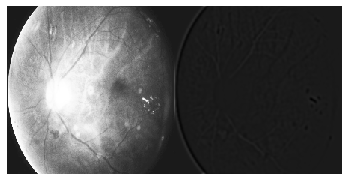

In [124]:
res = np.hstack((equ,result))
plt.axis('off')
plt.imshow(res,cmap='gray')
plt.show()

In [118]:
data_array = np.array(data_array)
norm_one = (data_array - np.mean(data_array)) / math.sqrt(np.var(data_array))
data_array = data_array.flatten().reshape(n,-1)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(data_array,Y, test_size=0.25, random_state=42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(2655, 50176), (2655,)
Test data and target sizes: 
(885, 50176), (885,)


**PCA + SVM**

In [57]:
# Preprocessing with PCA
reduced_pca = PCA(n_components=0.85)
reduced_pca.fit(X_train)
X_train_reduced = reduced_pca.transform(X_train)
X_test_reduced = reduced_pca.transform(X_test)
print("Reduced Shape:", X_train_reduced.shape)

Reduced Shape: (2655, 146)


In [58]:
#reduced_pca.explained_variance_ratio_

In [59]:
X_train_reduced.shape

(2655, 146)

In [60]:
clf = svm.SVC(gamma='auto')
starting_time = time.process_time()
clf.fit(X_train_reduced,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", clf.score(X_test_reduced, y_test))

Data fitting takes 4.594767999999931 seconds
Testing Accuracy 0.43954802259887005


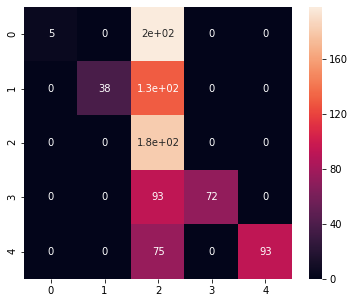

              precision    recall  f1-score   support

         0.0       1.00      0.02      0.05       203
         1.0       1.00      0.23      0.37       168
         2.0       0.27      1.00      0.42       181
         3.0       1.00      0.44      0.61       165
         4.0       1.00      0.55      0.71       168

    accuracy                           0.44       885
   macro avg       0.85      0.45      0.43       885
weighted avg       0.85      0.44      0.42       885



In [61]:
y_pred = clf.predict(X_test_reduced)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))

**KMeans + SVM**

In [120]:
# Preprocessing with KMeans
# Rule of thumb for picking K

k = math.sqrt(X_train.shape[0]/2)
kmnist_kmeans = KMeans(n_clusters=int(k), max_iter = 1000).fit(X_train)
X_train_cluster = kmnist_kmeans.transform(X_train)
X_test_cluster = kmnist_kmeans.transform(X_test)
print("Reduced Shape:", X_train_cluster.shape)

Reduced Shape: (2655, 36)


In [121]:
kmean_svm = svm.SVC(gamma=0.001, class_weight='balanced')
starting_time = time.process_time()
kmean_svm.fit(X_train_cluster,y_train)
print("Data fitting takes", time.process_time() - starting_time, "seconds")
print("Testing Accuracy", kmean_svm.score(X_test_cluster, y_test))

Data fitting takes 2.091501999999309 seconds
Testing Accuracy 0.43728813559322033


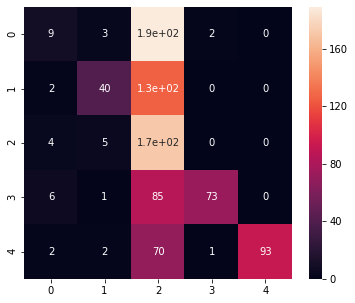

              precision    recall  f1-score   support

         0.0       0.39      0.04      0.08       203
         1.0       0.78      0.24      0.37       168
         2.0       0.27      0.95      0.42       181
         3.0       0.96      0.44      0.61       165
         4.0       1.00      0.55      0.71       168

    accuracy                           0.44       885
   macro avg       0.68      0.45      0.44       885
weighted avg       0.66      0.44      0.42       885



In [122]:
y_pred = kmean_svm.predict(X_test_cluster)
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_ylim(5.0, 0)
plt.show()

print(classification_report(y_test,y_pred))